In [38]:
# import all necessary libraries
%pip install torch
import torch
%pip install torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import random_split, DataLoader

import torch.nn as nn
import torch.optim as optim

import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\15716\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\15716\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [39]:
# Crearting dataset objects
dataset = FashionMNIST(root='/data', download=True, transform=transforms.ToTensor())
complete_ds = FashionMNIST(root='/data', train=True, transform=transforms.ToTensor()) # complete train dataset
test_ds = FashionMNIST(root='/data', train=False, transform=transforms.ToTensor()) # complete test dataset
len(complete_ds),  len(test_ds)

(60000, 10000)

In [40]:
# Split the training data between valid and train data
train_ds, valid_ds = random_split(complete_ds, [50000, 10000])
len(train_ds), len(valid_ds), len(test_ds)

(50000, 10000, 10000)

In [41]:
# Creating the dataloader
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

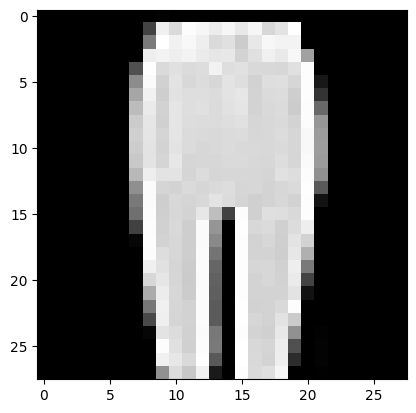

In [42]:
X, y = train_ds[0]
import matplotlib.pyplot as plt
plt.imshow(X.reshape(28, 28), cmap='gray')

In [43]:
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [44]:
class MLP(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(MLP, self).__init__()

        #layers
        #self.hidden = nn.Linear(in_size, hidden_size)
        #self.output = nn.Linear(hidden_size, out_size)
        # network
        self.network = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )

    def forward(self, x):
        xb = x.view(-1,784)
        #z1 = torch.relu(self.hidden(xb))
        #raw_preds = self.output(z1)
        raw_preds = self.network(xb)
        return raw_preds

In [45]:
model = MLP(784, 100, 10)
ce_loss = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.001)

In [46]:
def evaluate(model, loader):
    correct = 0
    total = 0
    for (X, y) in iter(loader):
        raw_preds = model.forward(X)
        preds = torch.softmax(raw_preds, dim=1)
        max_val, pred_labels = torch.max(preds, dim=1)

        correct += (pred_labels==y).sum()
        total += len(X)

    return (correct/total)*100

In [55]:
res = pd.DataFrame()
for epoch in tqdm_notebook(range(100)):
    for (X, y) in iter(train_loader):
        raw_preds = model.forward(X) # forward
        loss = ce_loss(raw_preds, y) # loss
        loss.backward() # backward
        opt.step() # update weights and bias in complete network
        opt.zero_grad()

    val_accuracy = evaluate(model, valid_loader)
    test_accuracy = evaluate(model, test_loader)
    res = pd.concat([res, pd.DataFrame([[epoch, val_accuracy.item(), test_accuracy.item()]])])

  0%|          | 0/100 [00:00<?, ?it/s]

In [56]:
res.columns = ["epoch", "val_accuracy", "test_accuracy"]
res

,epoch,val_accuracy,test_accuracy
0,0,67.150002,65.979996
0,1,67.820000,66.409996
0,2,68.239998,66.930000
0,3,68.540001,67.360001
0,4,69.220001,67.879997
...,...,...,...
0,95,83.510002,81.980003
0,96,83.420006,81.970001
0,97,83.420006,81.930000
0,98,83.520004,81.879997


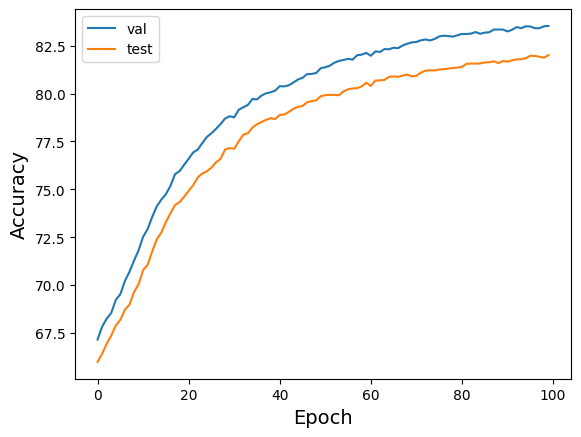

In [57]:
fig, ax = plt.subplots()
ax.plot(res["epoch"], res["val_accuracy"], label="val")
ax.plot(res["epoch"], res["test_accuracy"], label="test")
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Accuracy", size=14)
ax.legend()
plt.show()